# Baseline рекомендательной системы сервиса про фильмы и все такое

Воспользуемся методом коллаборативной фильтрации (CF) для рекомендации пользователю фильмов, которые похожи на понравившиеся ему ранее (item-based CF). Другими словами, предскажем оценки фильмов, которые пользователь еще не смотрел.

![матрица предпочтений](http://habrastorage.org/files/624/69d/7d9/62469d7d95944cf9b25d4096107a1596.png)

У этого метода есть недостатки: проблема холодного старта и плохих предсказаний для нетипичных объектов, статичность рекомендаций, — но на первом этапе мы будем использовать эту модель как опорную для развития.

В основе CF лежат методы разложения матрицы предпочтений, идея которых в том, что наше предсказание — есть скалярное произведение вектора некоторых параметров для пользователя на вектор некоторых параметров для фильма.

![SVD](http://habrastorage.org/files/1d5/8ad/5fe/1d58ad5fe6a44bffaff537491f4cb458.png)

В качестве вычислителя попробуем итеративный алгоритм ALS (alternative least squares), который работает достаточно быстро и позволяет распараллеливать вычисления.

Источники
* https://habr.com/ru/company/yandex/blog/241455/
* https://habr.com/ru/company/lanit/blog/421401/

# Краткий анализ данных

Используем датасет с оценками пользователей сайта kinopoisk.ru.

In [ ]:
%%time

from datetime import datetime
import pandas as pd


ratings_csv = '../input/kinopoisk-movies-and-votes/movie_votes.csv'
ratings = pd.read_csv(
    ratings_csv, sep='|', parse_dates=['time'], date_parser=lambda ts: datetime.fromtimestamp(int(ts))
)

In [ ]:
print('Количество строк:', ratings.shape[0])
ratings.head()

In [ ]:
ratings.time.dt.year.value_counts(sort=False).plot(
    kind='barh', figsize=(12, 8), title='Cколько фильмов оценили пользователи'
);

In [ ]:
ax = ratings.score.value_counts(sort=False).plot(
    kind='bar', figsize=(6, 6), title='Какие оценки ставят пользователи'
)
ax.annotate(
    ratings.score.describe().round(2).to_string(),
    (0.4, 0.95),
    xycoords='axes fraction',
    va='top',
    ha='right',
);

In [ ]:
ax = ratings.user_id.value_counts().plot(
    kind='hist', bins=50, figsize=(12, 6), title='Сколько оценок ставят пользователи'
)
ax.annotate(
    ratings.user_id.value_counts().describe().round(2).to_string(),
    (0.95, 0.95),
    xycoords='axes fraction',
    va='top',
    ha='right',
);

# Модель

Преобразуем явную оценку пользователя в неявный показатель, полагая, например, что позитивная оценка не меньше 7. Неявную обратную связь (просмотры, закладки и все такое) легче собрать на раннем этапе развития сервиса.

In [ ]:
%pip install -q implicit

In [ ]:
import numpy as np
from scipy.sparse import csr_matrix


MIN_RATING = 7
MIN_YEAR = 2008


implicit_ratings = ratings.query(f'score >= {MIN_RATING} & time.dt.year >= {MIN_YEAR}')[['user_id', 'movie_id']].values

users, user_inds = np.unique(implicit_ratings[:, 0], return_inverse=True)
items, item_inds = np.unique(implicit_ratings[:, 1], return_inverse=True)

item_user = csr_matrix((np.ones(implicit_ratings.shape[0]), (item_inds, user_inds)), shape=(len(items), len(users)))
item_user

In [ ]:
from implicit.evaluation import train_test_split


# random split
train, test = train_test_split(item_user)
print('train', repr(train), 'test', repr(test), sep='\n')

In [ ]:
from implicit.als import AlternatingLeastSquares


model = AlternatingLeastSquares(factors=50, regularization=0.05, iterations=15)
model.fit(train)

# Метрики

In [ ]:
from implicit.evaluation import train_test_split, ranking_metrics_at_k


ranking_metrics_at_k(model, train.T, test.T, K=10, num_threads=0)

Судя по метрике AUC наша модель предсказывает чуть лучше, чем случайно :) Но если опираться на SOTA рекомендательных систем https://github.com/microsoft/recommenders, наши результаты неплохие.

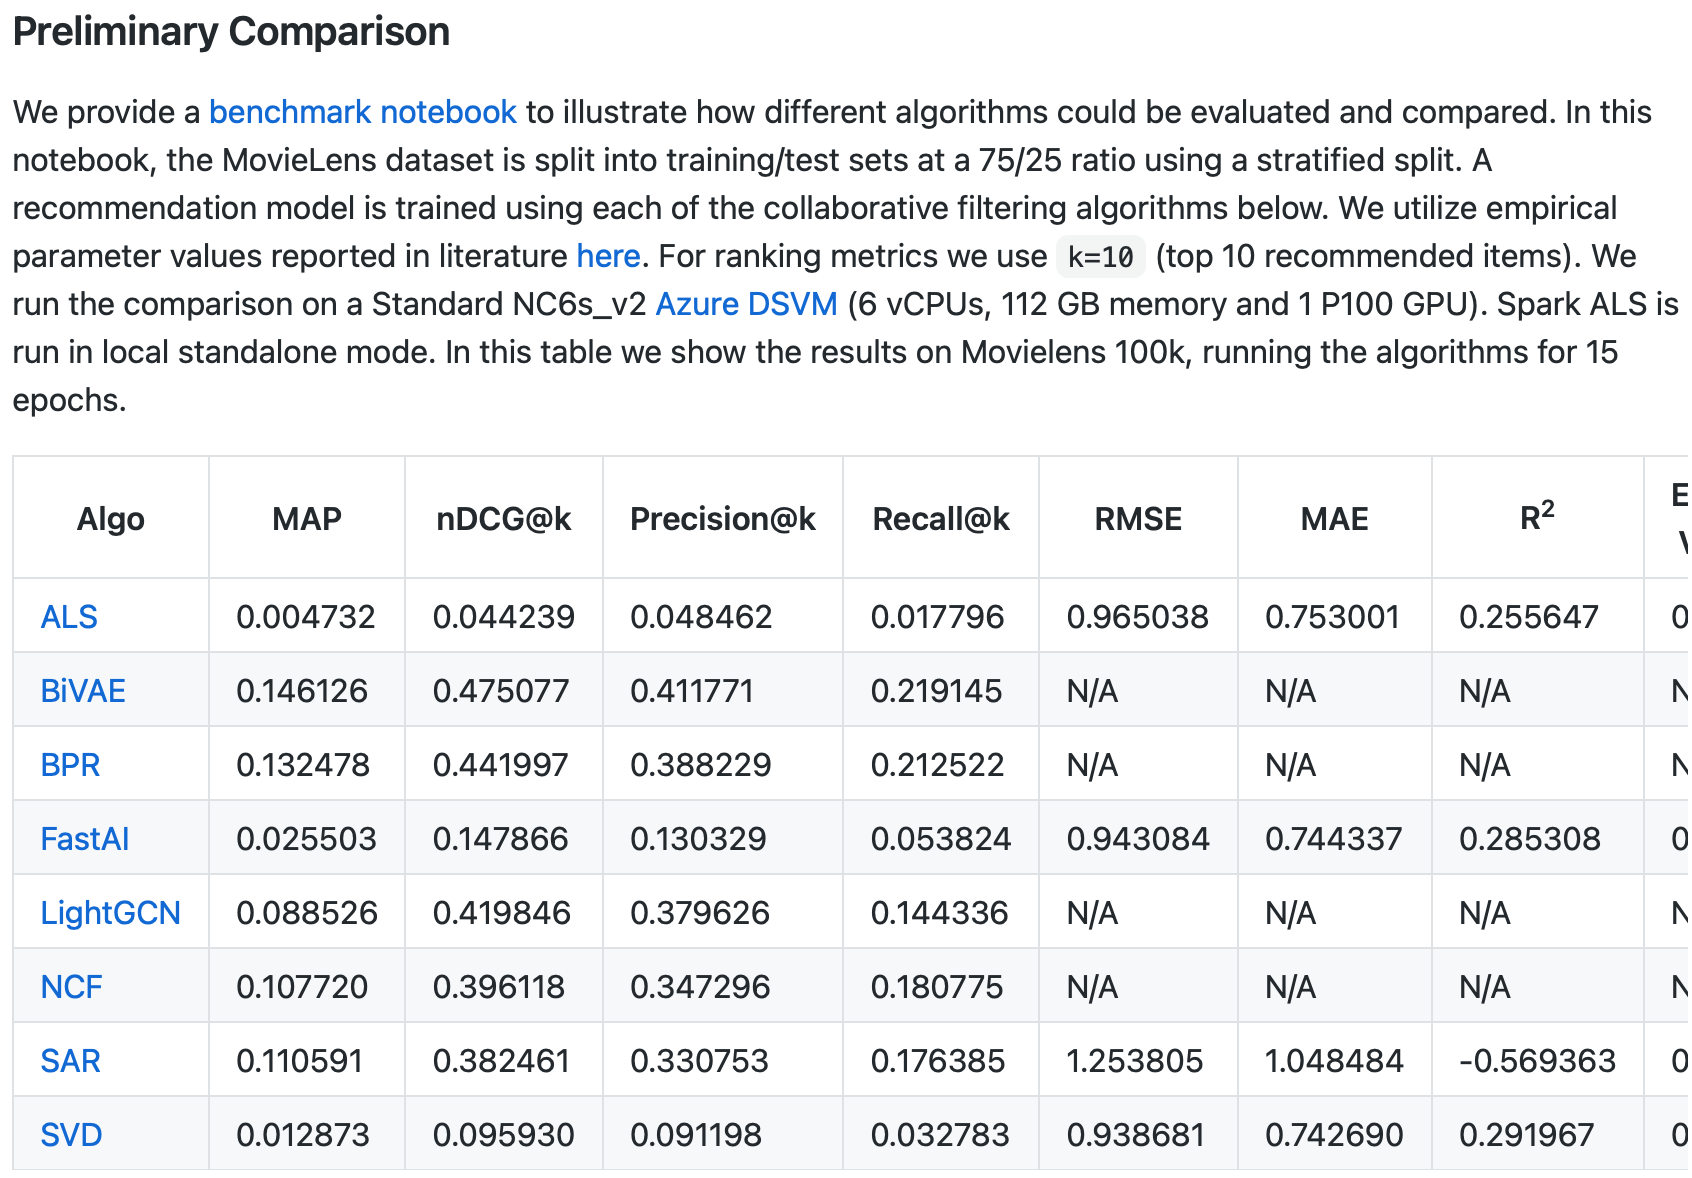

Про метрики https://habr.com/ru/company/econtenta/blog/303458/

# Пример использования

Посмотрим рекомендации для случайного пользователя.

In [ ]:
movies_csv = '../input/kinopoisk-movies-and-votes/movie_info.csv'
movies = pd.read_csv(movies_csv, sep='|')

In [ ]:
target_user_id = np.random.randint(0, len(users))

liked = train.T[target_user_id].nonzero()[1]
recs = model.recommend(target_user_id, train.T, N=20, filter_items=list(liked))

In [ ]:
print('Понравившиеся пользователю фильмы')
user_likes = ratings[(ratings.user_id == users[target_user_id]) & (ratings.score >= MIN_RATING)]
user_likes.merge(movies, left_on='movie_id', right_on='id')['title_russian'].sample(20).tolist()

In [ ]:
print('Рекомендации')
movies[movies.id.isin(items[[item_id for item_id, _ in recs]])]['title_russian'].tolist()